# generate porec_read_rDNA_position.bed(cut the overlapping edge of alignments)

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow
import pyarrow.parquet as pq
from pathlib import Path
from pathlib import PurePath
import seaborn as sns
import pypairix

In [18]:
%%writefile "/public/home/lizw/task/pore_c/rDNA3/generate_porec_read_rDNA_position.py"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow
import pyarrow.parquet as pq
from pathlib import Path
from pathlib import PurePath
import seaborn as sns
import pypairix

porec_dir = '/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result'
prefix = 'DpnII_run13'
mpq=1

align_dir = Path(PurePath(porec_dir,'align_table'))
align_dir_porec_generator = align_dir.glob(prefix + "*pore_c.parquet")
align_batch_porec_merge_df = pyarrow.concat_tables(list(map(pq.read_table,align_dir_porec_generator))).to_pandas()
align_batch_porec_merge_df_pass = align_batch_porec_merge_df.query('pass_filter==True').query('mapping_quality>=@mpq')
align_batch_porec_merge_df_pass_sort = align_batch_porec_merge_df_pass.sort_values(by=['read_name','read_start']).reindex(['chrom','start','end','strand','read_length','read_name','align_idx','read_start','read_end'],axis=1)
align_batch_porec_merge_df_pass_sort['align_name'] = align_batch_porec_merge_df_pass_sort['read_name'].str.cat(align_batch_porec_merge_df_pass_sort['align_idx'].astype('str'),sep="_")

from concurrent import futures
def remove_edge_overlap_thread(func,iter_object,max_workers):
    workers = min(max_workers,len(iter_object))
    with futures.ThreadPoolExecutor(workers) as excutors:
        res = excutors.map(func,iter_object)
    return list(res)

def remove_edge_overlap(group):
    last_read_end = 0
    group_df = group[1]
    for items in group_df.itertuples():
        index,chrom,start,end,strand,read_length,read_name,align_idx,read_start,read_end,align_name = items
        if read_start < last_read_end:
            cut_length = last_read_end - read_start
            group_df.loc[index,'read_start'] = last_read_end
            if strand == True:
                group_df.loc[index,'start'] = group_df.loc[index,'start'] + cut_length
            elif strand == False:
                group_df.loc[index,'end'] = group_df.loc[index,'end'] - cut_length
        last_read_end = read_end
    return group_df

group = align_batch_porec_merge_df_pass_sort.groupby(by='read_name')
align_batch_porec_merge_df_pass_sort_mod = pd.concat(remove_edge_overlap_thread(remove_edge_overlap,group,30),axis=0)

align_batch_porec_merge_df_pass_sort_mod.to_csv('/public/home/lizw/task/pore_c/rDNA3/align_batch_porec_merge_df_pass_sort_cutover.csv')
align_batch_porec_merge_df_pass_sort_mod.reindex(['read_name','start','end','align_name'],axis=1).to_csv('/public/home/lizw/task/pore_c/rDNA3/read_chrom_position_cutover.bed',index=None,header=None,sep="\t")

Overwriting /public/home/lizw/task/pore_c/rDNA3/generate_porec_read_rDNA_position.py


# intersect

# v3 for porec_filter intersect result

In [19]:
%%writefile "/public/home/lizw/task/pore_c/rDNA3/rDNA_clusters_filter3.py"
import pandas as pd
intersect_df = pd.read_table("/public/home/lizw/task/pore_c/rDNA3/intersect_0.1.tsv",header=None,names=['read_name1','start1','end1','align1','read_name2','start2','end2','align2'])
#keep only the read2 that located at the right side of the read1
intersect_df_single_dir = intersect_df.query('start1 <= start2')
intersect_df_sort = intersect_df_single_dir.sort_values(by=['read_name1','start1','end1'])
intersect_df_sort.to_csv('/public/home/lizw/task/pore_c/rDNA3/porec_filter_sorted_intersect_0.1.csv')
#must turn off the groupby sort to keep the original order !!!!
intersect_df_alignID = pd.DataFrame(intersect_df_sort.groupby('align1',sort=False).apply(lambda x:set(x['align2'])))
intersect_df_alignID.to_csv('/public/home/lizw/task/pore_c/rDNA3/porec_filter_intersect_df_alignID2.csv')
intersect_df_alignID['read_name'] = [x[0] for x in intersect_df_alignID.index.str.split("_")]

group = intersect_df_alignID.groupby(by='read_name',sort=False)

def filter(group):
    group_df = group[1]
    base_align = ''
    base_set = set()
    align_keep=[]
    singleton=[]
    for i in group_df.itertuples():
        align1,align_set,read_name = i
       #keeps align_set that contain interactions
        if len(align_set) < 2:
            singleton.append(align1)
        #no overlap, keep both
        elif len(base_set&align_set) == 0:
            align_keep.append(align1)
            base_set = align_set
            base_align = align1
        else:
            #if there are overlap, keeps only the largest set
            if len(align_set) > len(base_set):
                if base_align in align_keep:
                    align_keep.remove(base_align)
                align_keep.append(align1)
                base_set = align_set
                base_align = align1

            #the base set would be keep until it is smaller than other groups
            else:
                continue
    result_list = (align_keep,singleton)
    return result_list

from concurrent import futures
def filter_thread(func,iter_object,max_workers):
    workers = min(max_workers,len(iter_object))
    with futures.ThreadPoolExecutor(workers) as excutors:
        res = excutors.map(func,iter_object)
    return list(res)
    

from itertools import chain
align_both_list = filter_thread(filter,group,30)
#align_both_all = list(chain(*align_both_list))

interactions = []
singleton = []
for x in align_both_list:
    interactions.extend(x[0])
    singleton.extend(x[1])
    
intersect_df_filter = intersect_df_sort.query('align1 in @interactions')
intersect_df_filter.to_csv('/public/home/lizw/task/pore_c/rDNA3/porec_filter_intersect_df_filter2.csv')

all_align = []
all_align.extend(singleton)
all_align.extend(interactions)
all_filter = intersect_df_sort.query('align1 in @all_align')
all_filter.to_csv('porec_filter_all_filter.csv')

Overwriting /public/home/lizw/task/pore_c/rDNA3/rDNA_clusters_filter3.py


# site distribution

In [21]:
import pandas as pd 
intersect_df_filter = pd.read_csv("/public/home/lizw/task/pore_c/rDNA3/porec_filter_intersect_df_filter2.csv")
df_interaction_size = intersect_df_filter.groupby(by='align1').size()

In [22]:
df_interaction_size.value_counts()

2     139518
3      14855
4       3218
5        538
6        131
7         22
8         11
9          1
10         1
dtype: int64

In [23]:
#get the range of each inter-rDNA interacting groups
intersect_df_min = intersect_df_filter.groupby('align1').apply(lambda x:min(x['start2'].min(),x['end2'].min()))
intersect_df_max = intersect_df_filter.groupby('align1').apply(lambda x:max(x['start2'].max(),x['end2'].max()))
intersect_df_min.name='posmin'
intersect_df_max.name='posmax'

intersect_df_merge = pd.merge(intersect_df_min,intersect_df_max,on='align1')
intersect_df_merge = intersect_df_merge.assign(length=lambda df:df['posmax']-df['posmin'],mid=lambda df:(df['posmax']+df['posmin'])//2)
intersect_df_merge.to_csv("/public/home/lizw/task/pore_c/rDNA3/interacting_group_position2")

In [14]:
intersect_df_merge = pd.read_csv('/public/home/lizw/task/pore_c/rDNA3/interacting_group_position2')

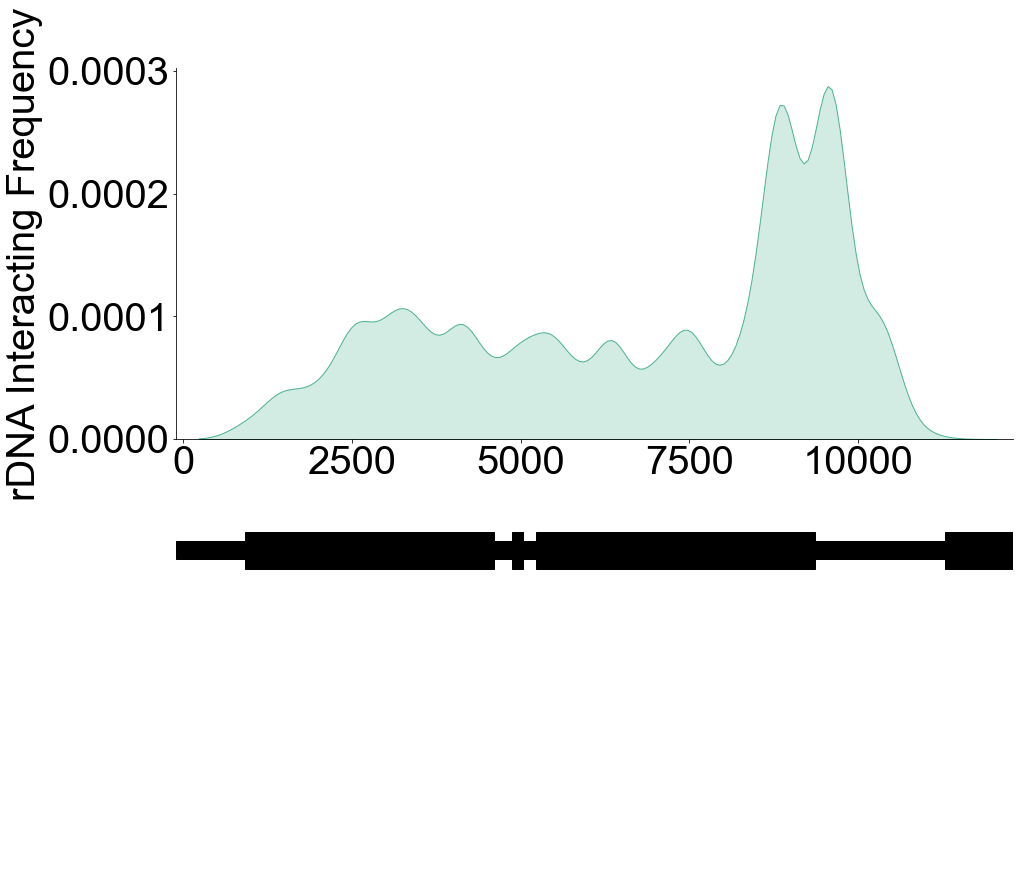

In [131]:
#binsize = 200
region_start = 0
region_end = 12204
# df_cut_all,df_bins_all= pd.cut(intersect_df_merge['mid'],bins=range(region_start,region_end+binsize-1,binsize),precision=0,retbins=True)
# intersect_df_merge['interval']  = df_cut_all
# intersect_df_merge_count = intersect_df_merge.groupby('interval').size()

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
import seaborn as sns
import matplotlib.font_manager as font_manager
import statsmodels.api as sm
from scipy.stats import norm

font_dirs = ["/public/home/lizw/software/font"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 40
fig,ax = plt.subplots(nrows=2,figsize=(15,15))

#make cutting edge for kde
sns.kdeplot(intersect_df_merge['mid'],shade=True,color = '#4CB391',cut=0,ax=ax[0])

#intersect_df_merge['mid'].plot(kind='kde',color = '#3C8C6F',linewidth=5)
#intersect_df_merge_count.plot(kind='bar',ax=ax,width = 1,ec='white',color = '#3C8C6F')
#tickslist = np.arange(0,9400,2000)
ax[0].set_ylabel('rDNA Interacting Frequency')
ax[0].set_xlabel('Distance from rDNA Unit Start(bp)')
#plt.xticks(np.arange(0,3*len(tickslist),1*3) - 0.5,tickslist,rotation=30) 

#ax.spines['right'].set_visible(False)
ax[0].set_xlim(region_start-100,region_end+100)
ax[0].set_xlabel('')
sns.despine(left=True,bottom=True)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[0].spines['left'].set_visible(True)
ax[0].spines['bottom'].set_visible(True)


rDNA_unit_length = 12204
top = 0.9
last_end_plot = 0
rect3 = patches.Rectangle((0,top-0.025),(rDNA_unit_length - 0)/rDNA_unit_length,0.05,ec='k',color='k',zorder=0)
ax[1].add_patch(rect3)
#last_name = '0ede86d9-315d-4475-8a7d-dd61bf80d583'
rDNA_annotation = pd.read_table('/public/home/lizw/task/pore_c/rDNA3/anno.rDNA_extend1000.bed',header=None,names=['chrom','start','end','name'])
for i in rDNA_annotation.itertuples(index=False):
    chrom,start,end,name = i
    start_plot = start/rDNA_unit_length
    end_plot = end/rDNA_unit_length
    rect4 = patches.Rectangle((start_plot,top-0.05),end_plot-start_plot,0.1,color = 'k',zorder=1)
    ax[1].add_patch(rect4)
    last_end_plot = end_plot

plt.savefig('/public/home/lizw/task/pore_c/rDNA3/raw_count_rDNA_interaction_dist.png',format='png',bbox_inches='tight',dpi=300)

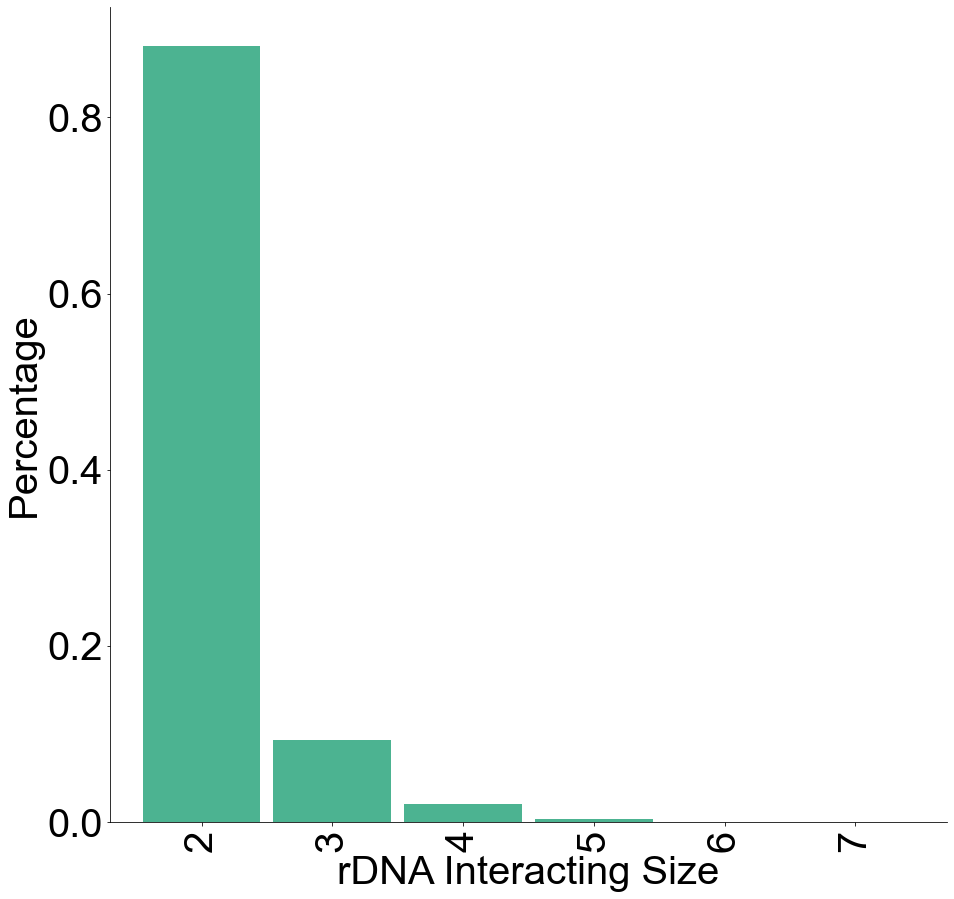

In [25]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
import seaborn as sns
import matplotlib.font_manager as font_manager
font_dirs = ["/public/home/lizw/software/font"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 40

fig, ax = plt.subplots(1,figsize=(15,15))
rDNA_cluster_size_all = intersect_df_filter.groupby(by='align1').size()
size_stat = rDNA_cluster_size_all.value_counts(normalize=True)
size_stat[size_stat.index<=7].plot(kind='bar',color = '#4CB391',ax=ax,width=0.9)
#rDNA_cluster_size_all.hist(bins=np.arange(bins_count+1)-0.5,density=1,edgecolor = 'w',ax=ax,color = '#385D8A')
ax.set_ylabel('Percentage')
ax.set_xlabel('rDNA Interacting Size')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
plt.savefig('/public/home/lizw/task/pore_c/rDNA3/raw_count_rDNA_interaction_size.png',format='png',bbox_inches='tight',dpi=300)

In [139]:
intersect_df_filter.query('(start1 >=0) & (start1< 1000)').groupby(by='align1').size().value_counts()

2    1722
3     170
4      23
5       4
dtype: int64

In [140]:
intersect_df_filter.query('(start1 >=1000) & (end1< 2000)').groupby(by='align1').size().value_counts()

2    3148
3     205
4      11
5       1
dtype: int64

In [141]:
intersect_df_filter.query('(start1 >=3000) & (end1< 4000)').groupby(by='align1').size().value_counts()

2    8833
3     675
4      65
5       8
6       3
dtype: int64

In [142]:
intersect_df_filter.query('(start1 >=4000) & (end1< 5000)').groupby(by='align1').size().value_counts()

2    4008
3     271
4      25
5       3
dtype: int64

In [143]:
intersect_df_filter.query('(start1 >=5000) & (end1< 6000)').groupby(by='align1').size().value_counts()

2    7255
3     650
4      70
5      10
6       3
dtype: int64

In [144]:
intersect_df_filter.query('(start1 >=6000) & (end1< 7000)').groupby(by='align1').size().value_counts()

2    5316
3     396
4      37
5       4
dtype: int64

In [145]:
intersect_df_filter.query('(start1 >=7000) & (end1< 8000)').groupby(by='align1').size().value_counts()

2    5693
3     482
4      47
5       4
6       1
dtype: int64

In [146]:
intersect_df_filter.query('(start1 >=7000) & (end1< 8000)').groupby(by='align1').size().value_counts()

2    5693
3     482
4      47
5       4
6       1
dtype: int64

In [147]:
intersect_df_filter.query('(start1 >=8000) & (end1< 9000)').groupby(by='align1').size().value_counts()

2    6691
3     525
4     121
5       7
6       3
8       1
dtype: int64

In [148]:
intersect_df_filter.query('(start1 >=9000) & (end1< 10000)').groupby(by='align1').size().value_counts()

2    22543
3     2073
4      767
5      105
6       29
7        3
8        2
dtype: int64

In [149]:
intersect_df_filter.query('(start1 >=10000) & (end1< 11000)').groupby(by='align1').size().value_counts()

2    399
3     10
dtype: int64

In [150]:
intersect_df_filter.query('(start1 >=11000) & (end1< 12000)').groupby(by='align1').size().value_counts()

2    8
dtype: int64

# make table with all information 

In [45]:
import pandas as pd

In [46]:
all_df = pd.read_csv('/public/home/lizw/task/pore_c/rDNA3/porec_filter_all_filter.csv')

In [47]:
all_df_filter_reindex = all_df.reindex(['align1','start2','end2','align2'],axis=1)
align_batch_porec_merge_df_pass_sort_mod = pd.read_csv('/public/home/lizw/task/pore_c/rDNA3/align_batch_porec_merge_df_pass_sort_cutover.csv',index_col=0)
align_batch_porec_merge_df_pass_sort_mod_reindex = align_batch_porec_merge_df_pass_sort_mod.reindex(['read_name','read_length','read_start','read_end','align_name'],axis=1)
read_pos_and_rDNA_pos = pd.merge(all_df_filter_reindex,align_batch_porec_merge_df_pass_sort_mod_reindex,left_on='align2',right_on='align_name',how='left')

/public/home/lizw/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# plot reads

In [48]:
rDNA_cluster_size_all[rDNA_cluster_size_all>=5]

align1
00d52e97-f744-44aa-880f-5e55414eca04_36973    6
01d2d56f-2c61-4821-af43-b10e8c8fa97d_4007     5
01fefe59-9112-4a53-9714-458294f76d58_22231    5
01fefe59-9112-4a53-9714-458294f76d58_22233    5
0226b7f4-f4e4-4906-89c7-796032c10c46_36850    7
                                             ..
fd5d36cc-1725-47c2-941e-e632b6473c7c_41524    5
fdf457e8-b5d4-40d7-8f32-04a4987ea42a_32423    5
fe8d7b61-8058-4dc9-baef-e7102d09994c_24870    5
ff7f2bdf-ca03-4220-b0ab-f1b1f9038777_11785    5
ffd319d8-040d-4c71-975a-3fe94f979549_57418    5
Length: 704, dtype: int64

In [90]:
example_list = ["0ede86d9-315d-4475-8a7d-dd61bf80d583","4ab4074d-a5f3-40cf-a3f4-d8b6c630d618","b7e0c335-b6e2-4e42-aee1-b18543d3da69"]

In [91]:
example_df = read_pos_and_rDNA_pos.query('read_name in @example_list').sort_values(by=['read_name','read_start'])

In [92]:
example_df_drop_du = example_df.drop_duplicates(subset='align2')

In [93]:
example_df_drop_du.groupby('read_name').size()

read_name
0ede86d9-315d-4475-8a7d-dd61bf80d583    17
4ab4074d-a5f3-40cf-a3f4-d8b6c630d618    13
b7e0c335-b6e2-4e42-aee1-b18543d3da69    12
dtype: int64

In [94]:
example_df_for_bed = example_df_drop_du

In [95]:
example_df_drop_du_read_pos = example_df_drop_du.reindex(['read_name','read_start','read_end'],axis=1)

In [96]:
example_df_drop_du_read_pos['name'] = example_df_drop_du_read_pos['read_name'].str.cat(example_df_drop_du_read_pos['read_start'].astype(str),sep='_')

In [97]:
example_df_drop_du_read_pos['name'] = example_df_drop_du_read_pos['name'].str.cat(example_df_drop_du_read_pos['read_end'].astype(str),sep='_')

In [98]:
example_df_drop_du_read_pos.to_csv('/public/home/lizw/task/pore_c/rDNA3/example_reads.bed',header=None,index=None,sep='\t')

# plot mapping

In [99]:
max_read_length = example_df['read_length'].max()
colorlist=['#C00000','#ED6D00', '#FFC000']

In [100]:
rDNA_annotation = pd.read_table('/public/home/lizw/task/pore_c/rDNA3/anno.rDNA_extend1000.bed',header=None,names=['chrom','start','end','name'])
rDNA_unit_length = 12204
colorlist=['#C00000','#ED6D00', '#FFC000']
example_df_drop_du.eval('fragment_length=read_end-read_start',inplace=True)
example_df_sort_map = example_df_drop_du.sort_values(by=['read_name','start2'])
example_df_sort_read = example_df_drop_du.sort_values(by=['read_name','read_start'])
read_list_sorted = list(example_df_sort_map['read_name'].drop_duplicates())
cutting_site = pd.read_csv('/public/home/lizw/task/pore_c/rDNA3/DpnII_rDMA_extend1000_DpnII.txt',sep=' ',header=None,index_col=0)
cutting_site_list = list(cutting_site.T['rDNA+-1000'])
cutting_site_list_draw =[x/max_read_length for x in cutting_site_list]

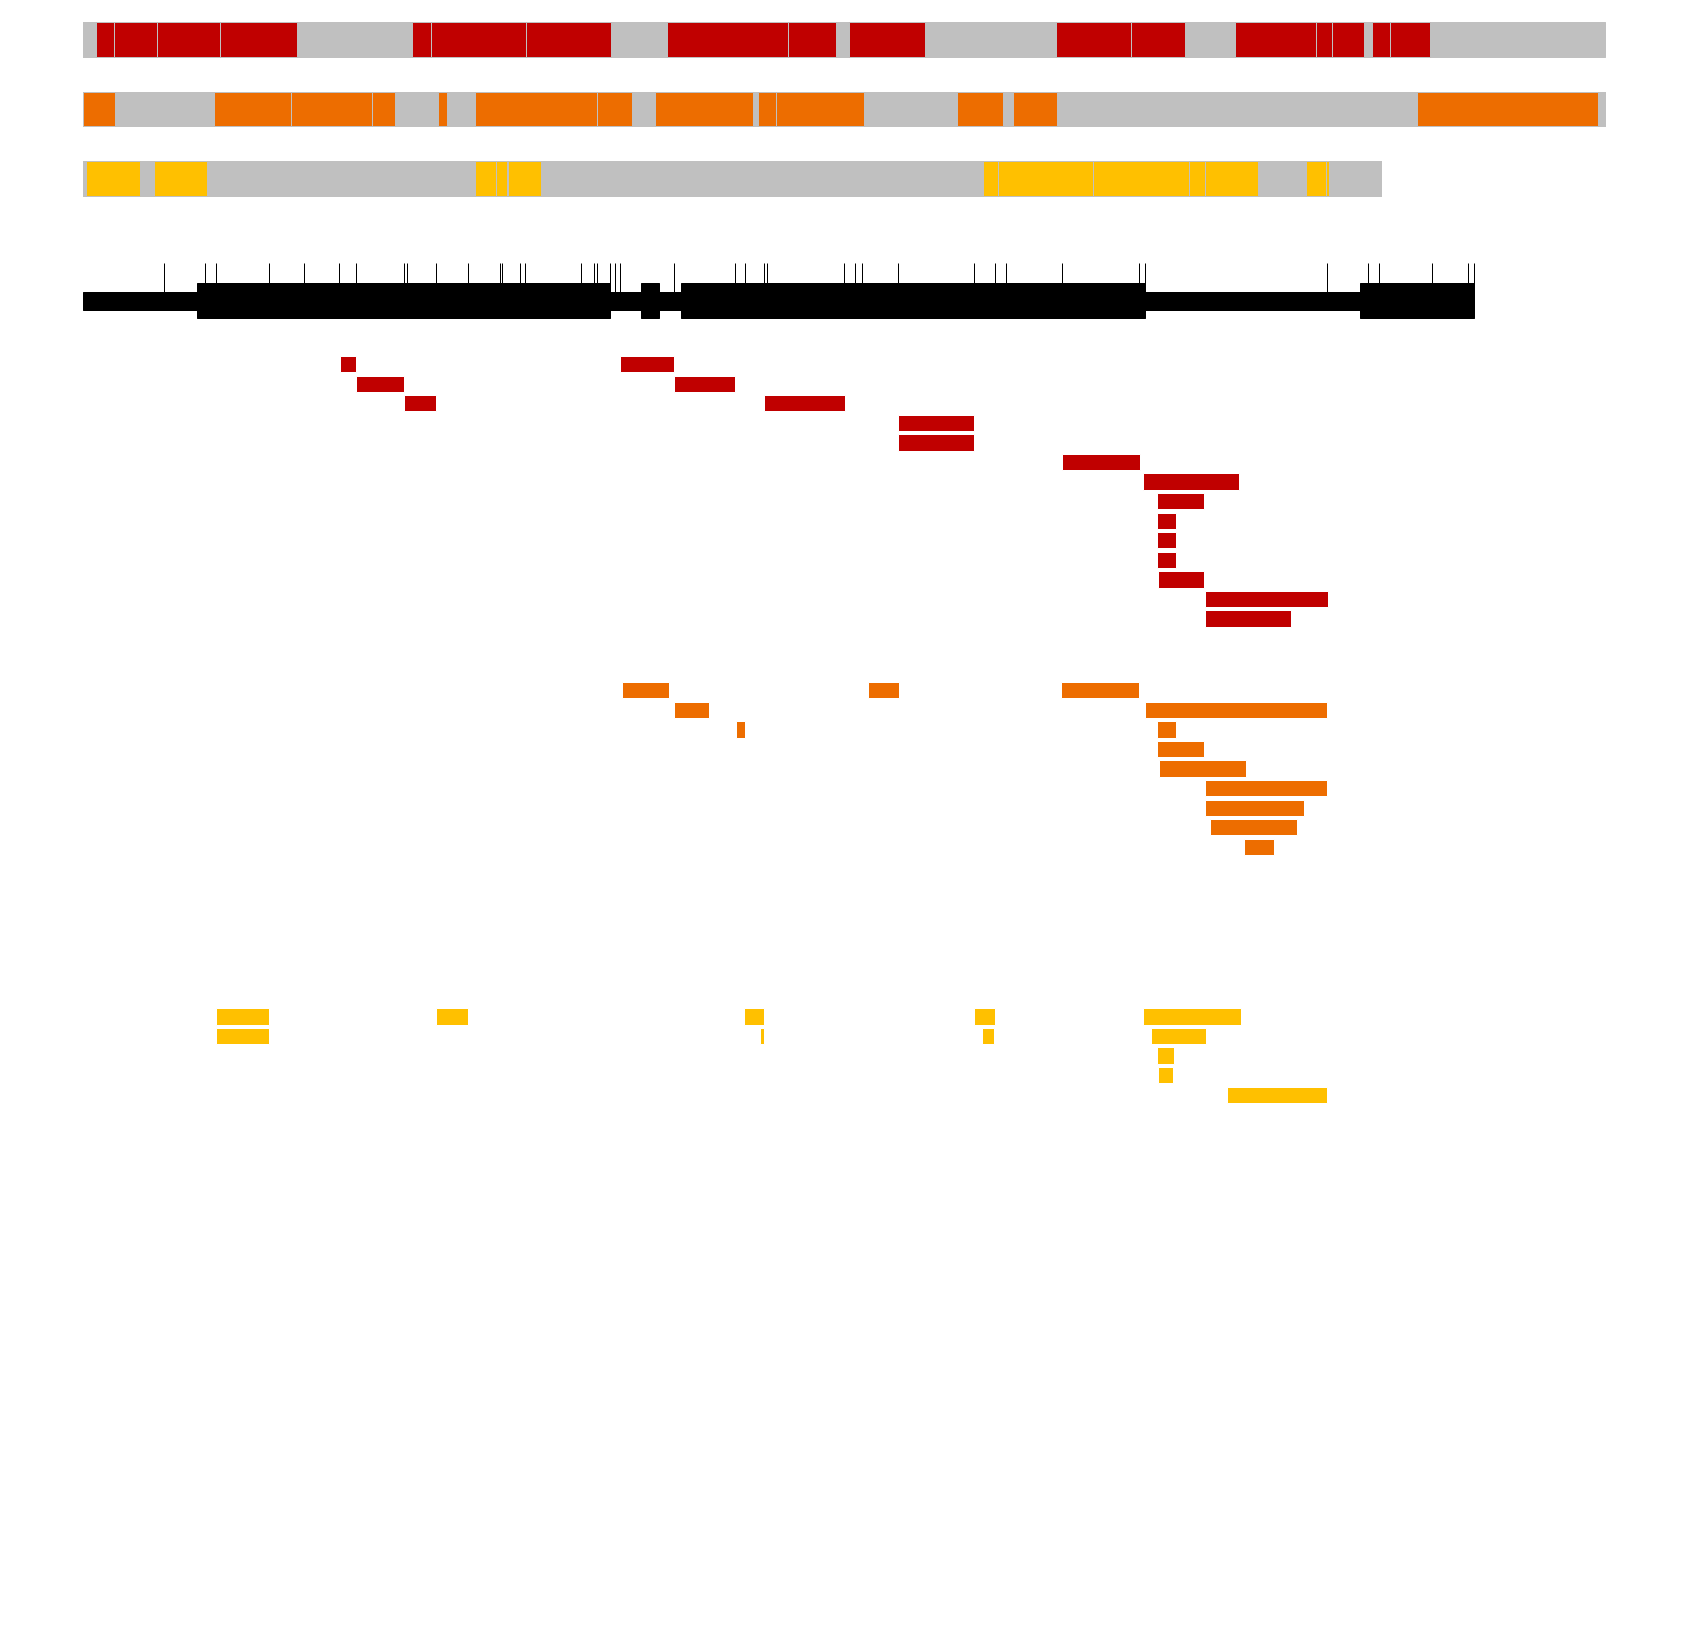

In [102]:
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
import seaborn as sns
import matplotlib.font_manager as font_manager

fig,ax = plt.subplots(nrows=5,figsize=(30,30),sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
sns.despine(left=True,bottom=True)
top = 0.90
top_step = 0.2
last_read_end_plot = 0
index=0
last_read_name = '0ede86d9-315d-4475-8a7d-dd61bf80d583'
for i in example_df_sort_read.itertuples(index=False):
    align1,geno_start,geno_end,align2,read_name,read_length,read_start,read_end,align_name,fragment_length = i
    rect1 = patches.Rectangle((0,top),read_length/max_read_length,0.1,ec='#C0C0C0',color='#C0C0C0',zorder=0)
    ax[0].add_patch(rect1)
    if read_name != last_read_name:
        top -= top_step
        last_read_end_plot = 0
        index += 1
    read_start_plot = read_start/max_read_length
    read_end_plot = read_end/max_read_length
    rect2 = patches.Rectangle((read_start_plot,top),read_end_plot-read_start_plot,0.1,ec ='#C0C0C0', color=colorlist[index],zorder=1)
    ax[0].add_patch(rect2)
    last_read_end_plot = read_end_plot
    last_read_name = read_name

ax[0].plot(cutting_site_list_draw,[0.25]*len(cutting_site_list_draw),'|',color='k',markersize=40)

for x in [0,1,2,3,4]:
    ax[x].set_xticks([])
    ax[x].set_yticks([])
top = 0.2
last_end_plot = 0
rect3 = patches.Rectangle((0,top-0.025),(rDNA_unit_length - 0)/max_read_length,0.05,ec='k',color='k',zorder=0)
ax[0].add_patch(rect3)
#last_name = '0ede86d9-315d-4475-8a7d-dd61bf80d583'
for i in rDNA_annotation.itertuples(index=False):
    chrom,start,end,name = i
    start_plot = start/max_read_length
    end_plot = end/max_read_length
    rect4 = patches.Rectangle((start_plot,top-0.05),end_plot-start_plot,0.1,color = 'k',zorder=1)
    ax[0].add_patch(rect4)
    last_end_plot = end_plot
    
top = 0.88
top_step = 0.06
index=1
last_geno_end = 0
last_read_name = '0ede86d9-315d-4475-8a7d-dd61bf80d583'
for i in example_df_sort_map.itertuples(index=False):
    align1,geno_start,geno_end,align2,read_name,read_length,read_start,read_end,align_name,fragment_length = i
    if read_name != last_read_name:
        index += 1
        top = 0.88
    if (geno_start-last_geno_end) > 1000:
        top = 0.88
    geno_start_plot = geno_start/max_read_length
    geno_end_plot = geno_end/max_read_length
    rect5 = patches.Rectangle((geno_start_plot,top),geno_end_plot-geno_start_plot,0.05,color=colorlist[index-1],zorder=2,ec='white')
    ax[index].add_patch(rect5)
    last_read_name = read_name
    last_geno_end = geno_end
    top -= top_step
plt.savefig('/public/home/lizw/task/pore_c/rDNA3/reads_example_map.png',format='png',dpi=300,bbox_inches='tight')

In [ ]:
example_df_drop_du.reindex(['read_name','read_start,read_end'])

# detial plot: show the read info as well as the mapping

In [88]:
def rDNA_detail(example):
    import matplotlib.pyplot as plt
    import matplotlib.path as mpath
    import matplotlib.patches as patches
    import seaborn as sns
    import matplotlib.font_manager as font_manager
    font_dirs = ["/public/home/lizw/software/font"]
    font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
    for font_file in font_files:
        font_manager.fontManager.addfont(font_file)
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = 30

    fig,ax = plt.subplots(1,figsize=(20,20))
    left = 0.07
    geno_max = 12000
    geno_start,geno_width = (0/geno_max,(9372+0)/geno_max)

    #rDNA annotation
    rDNA_annotation = pd.read_table('/public/home/lizw/task/pore_c/rDNA3/anno.rDNA_extend1000.bed',header=None,names=['chrom','start','end','name'])
    top = 0.95
    rect3 = patches.Rectangle((left,top-0.005),(rDNA_unit_length - 0)/geno_max,0.01,ec='k',color='k',zorder=0)
    ax.add_patch(rect3)
    for i in rDNA_annotation.itertuples(index=False):
        chrom,start,end,name = i
        start_plot = left + start/geno_max
        end_plot = left + end/geno_max
        rect4 = patches.Rectangle((start_plot,top-0.01),end_plot-start_plot,0.02,color = 'k',zorder=1)
        ax.add_patch(rect4)
        last_end_plot = end_plot
    #ticks
#     tickslist = np.arange(0,9400,2000)
#     ax.set_xlim(0,1)
#     ax.xaxis.tick_top()
#     ax.spines['top'].set_position(('data', 0.96))
#     plt.xticks(np.arange(0,9400,2000)/geno_max+left,tickslist,rotation=30)
#     plt.yticks([])
#     sns.despine(left=True,bottom=True)

    #cutting site
    cutting_site = pd.read_csv('/public/home/lizw/task/pore_c/rDNA3/DpnII_rDMA_extend1000_DpnII.txt',sep=' ',header=None,index_col=0)
    cutting_site_list = list(cutting_site.T['rDNA+-1000'])
    cutting_site_list_draw =[x/geno_max for x in cutting_site_list]
    ax.plot([x+left for x in cutting_site_list_draw],[0.97]*len(cutting_site_list_draw),'|',color='k',markersize=40)

    #main
    top = 0.85
    last_read_end = 0.85
    last_read_start = 0
    #last_read_end = 0
    last_start = geno_start
    last_end = geno_start+geno_width
    n=0
    for i in example.itertuples(index=False):
        align1,start,end,align2,read_name,read_max,read_start,read_end,align_name,fragment_length = i
        #to show the 1bp edgecutting
        read_end = read_end-1
        ax.plot([left+start/geno_max,left+end/geno_max],[top-read_start/read_max,top-read_start/read_max],'-',color='#d9534f',linewidth=5)
        ax.plot([0,0],[top-read_start/read_max,top-read_end/read_max],'-',color='#d9534f',linewidth=7)
        if n%2 == 1:
            ax.text(-0.001,top-read_start/read_max,s=f'{read_start}_',ha='right',fontsize=15)
        if n%2 == 0:
            ax.text(+0.001,top-read_start/read_max,s=f'_{read_start}',ha='left',fontsize=15)
        ax.plot([0,0],[top-last_read_end/read_max,top-read_start/read_max],'-',color='grey',linewidth=7)

        ax.plot([left+last_end/geno_max,left+start/geno_max],[top-last_read_start/read_max,top-read_start/read_max,],'--',color='grey')

        last_read_start = read_start
        last_read_end = read_end
        last_start = start
        last_end = end
        n += 1
    ax.plot([0,0],[top-last_read_end/read_max,top-read_max/read_max],'-',color='grey',linewidth=7)
    ax.plot([left+last_end/geno_max,left+start/geno_max],[top-last_read_start/read_max,top-read_max/read_max],'--',color='grey')
    sns.despine(left=True,bottom=True)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f'/public/home/lizw/task/pore_c/rDNA3/rDNA_interacting_example_detail_{read_name}.png',format='png',bbox_inches='tight',dpi=300)

In [86]:
example_list = ["01d2d56f-2c61-4821-af43-b10e8c8fa97d","00d52e97-f744-44aa-880f-5e55414eca04","0226b7f4-f4e4-4906-89c7-796032c10c46"]

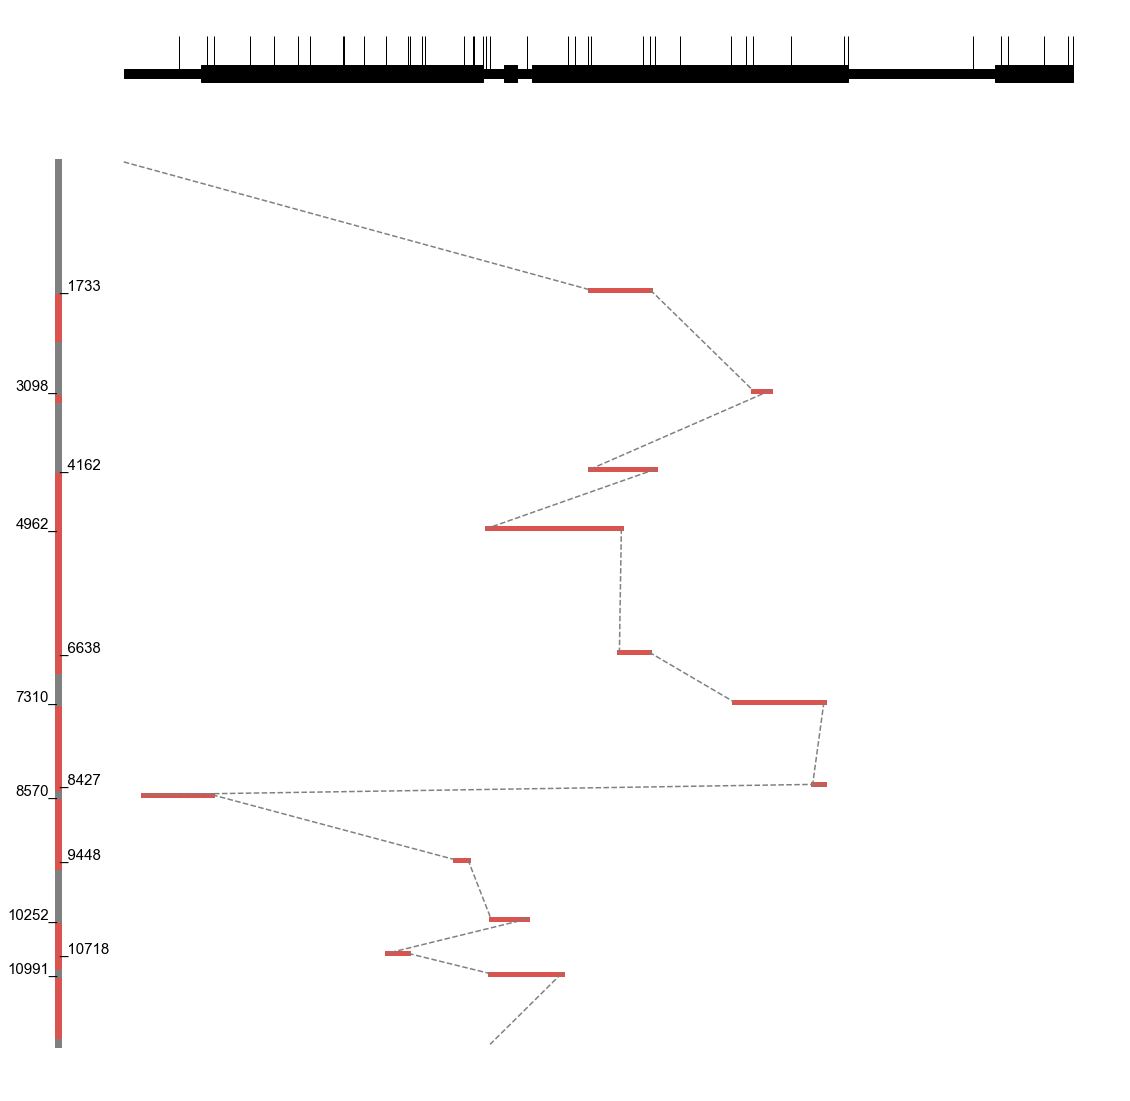

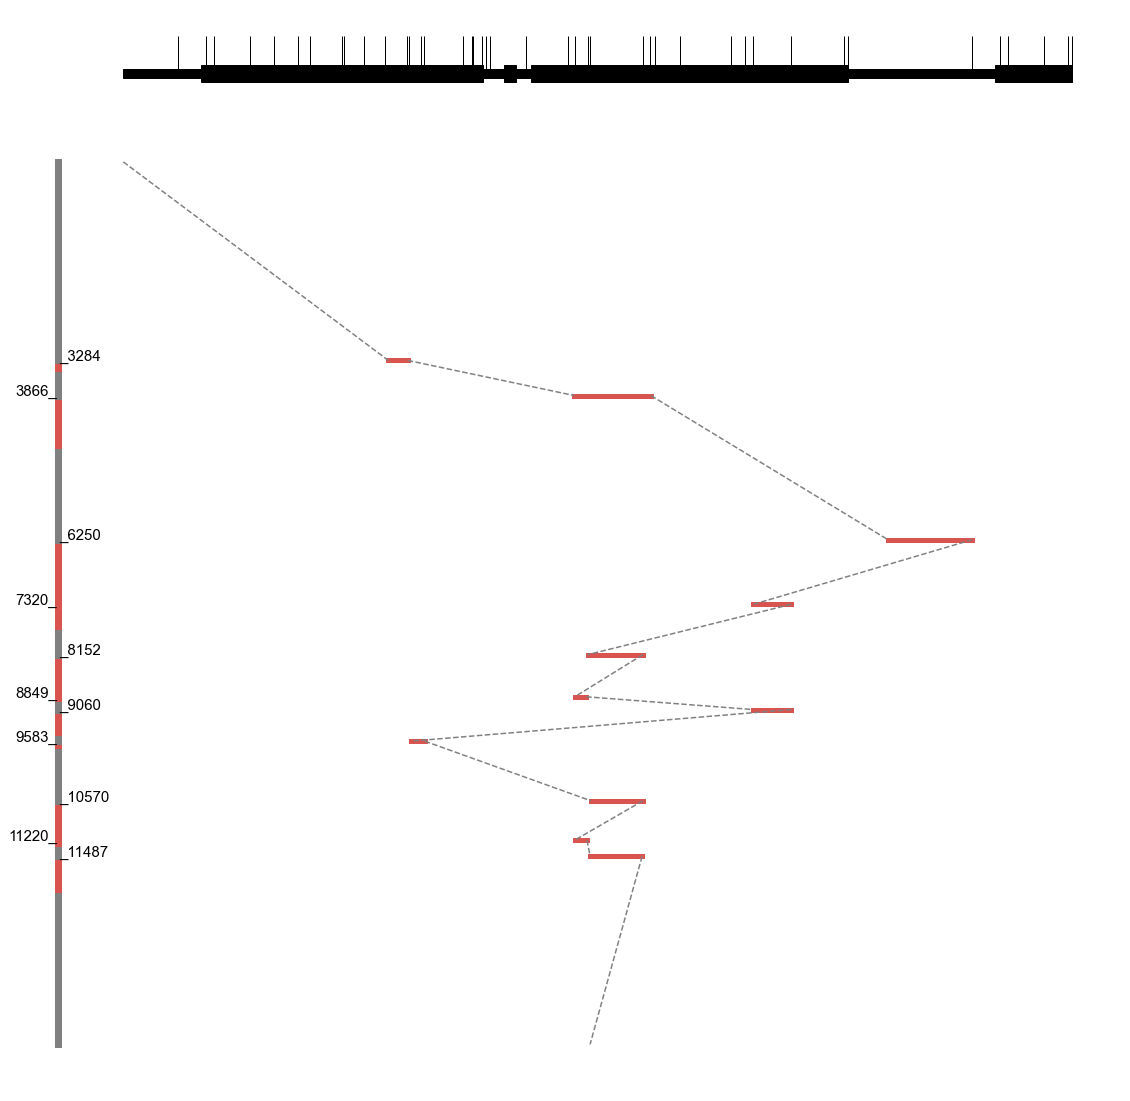

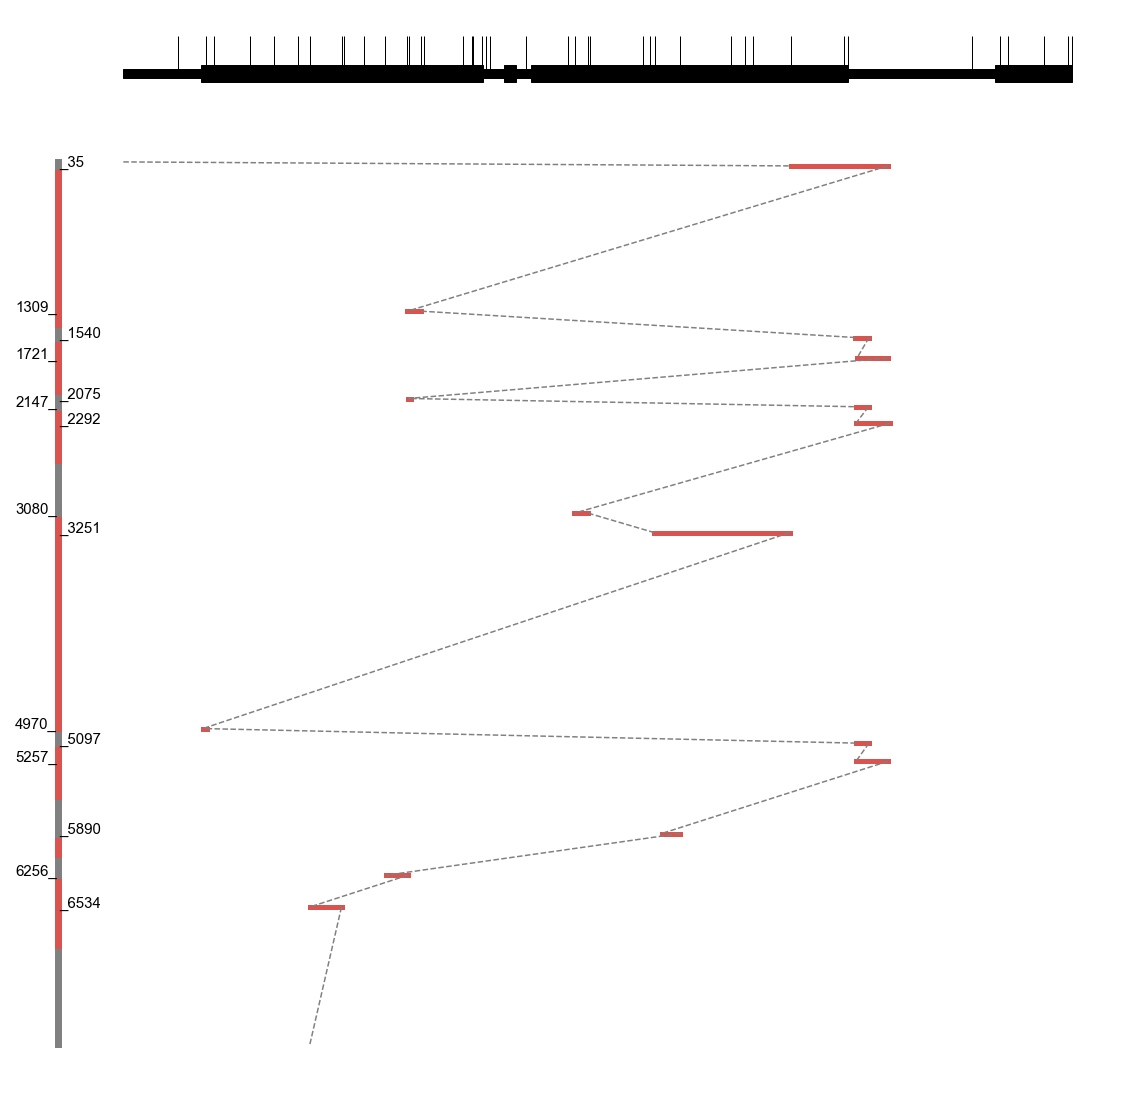

In [89]:
example_01d2d56f = example_df_drop_du.query('read_name == "01d2d56f-2c61-4821-af43-b10e8c8fa97d"')
example_00d52e97 = example_df_drop_du.query('read_name == "00d52e97-f744-44aa-880f-5e55414eca04"')
example_0226b7f4 = example_df_drop_du.query('read_name == "0226b7f4-f4e4-4906-89c7-796032c10c46"')
rDNA_detail(example_01d2d56f)
rDNA_detail(example_00d52e97)
rDNA_detail(example_0226b7f4)

In [ ]:
example_list = ["0ede86d9-315d-4475-8a7d-dd61bf80d583","4ab4074d-a5f3-40cf-a3f4-d8b6c630d618","b7e0c335-b6e2-4e42-aee1-b18543d3da69"]

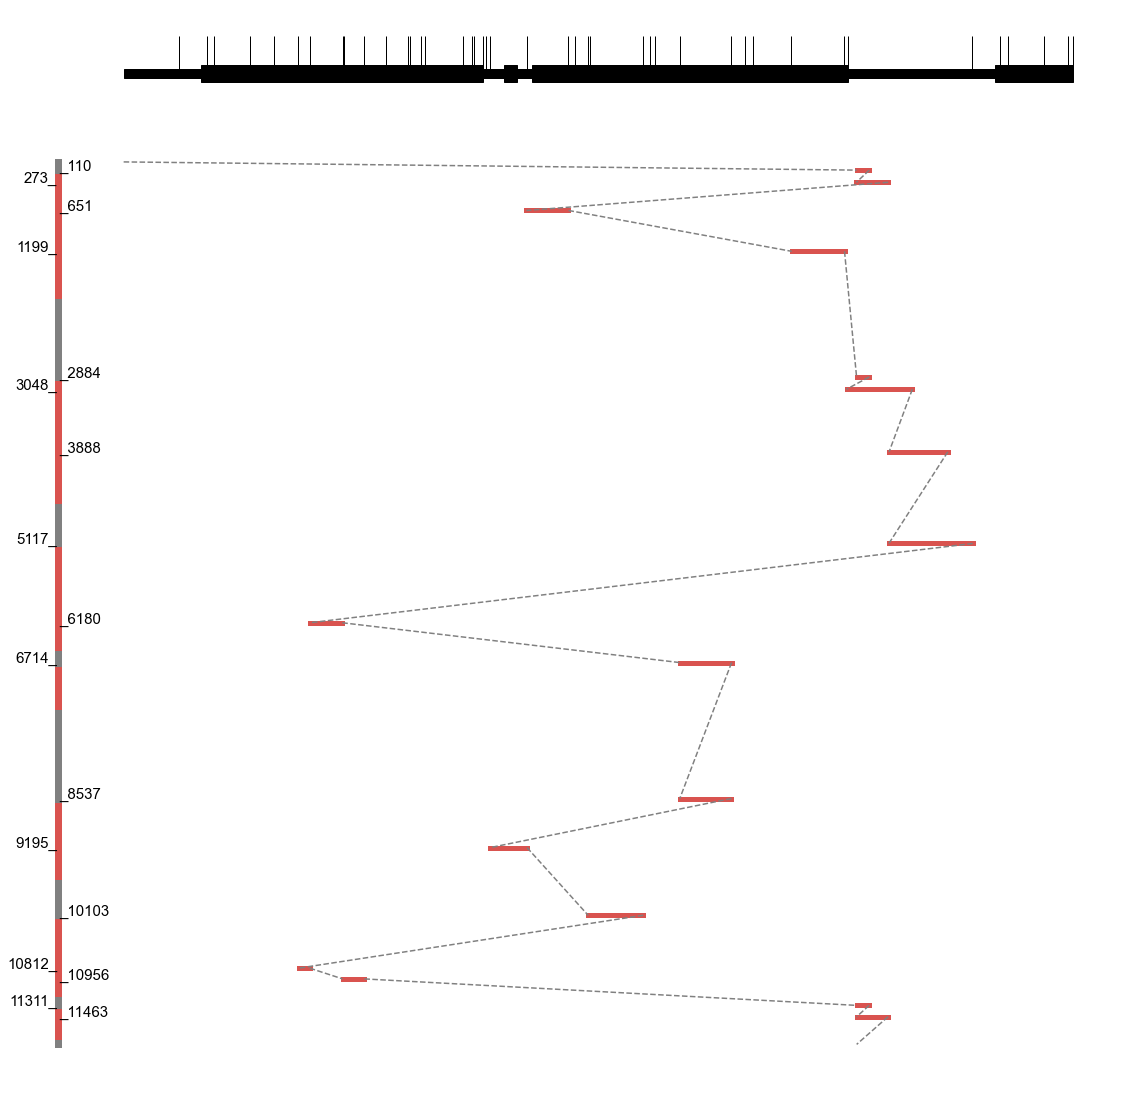

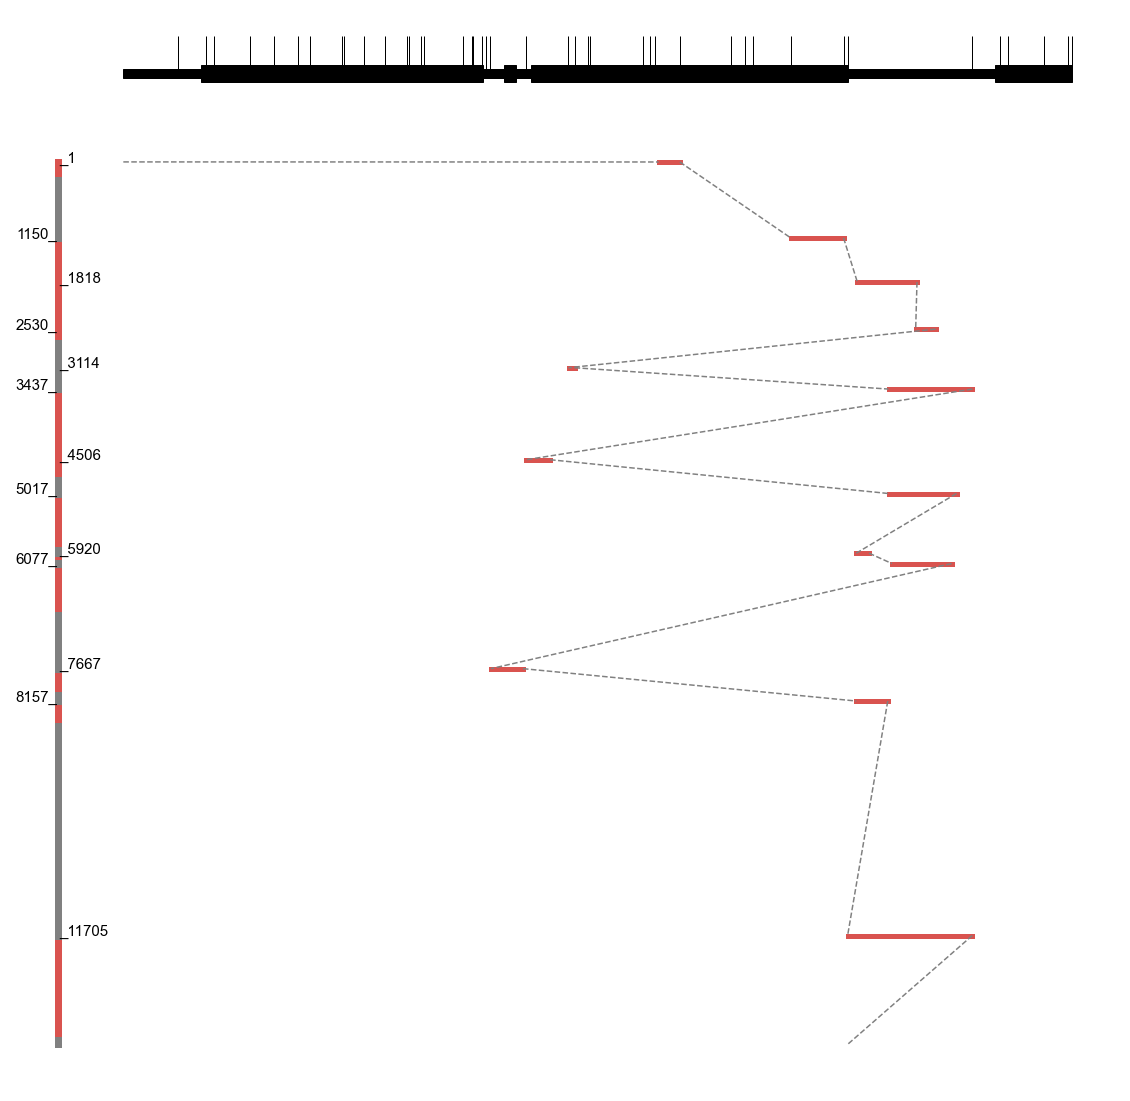

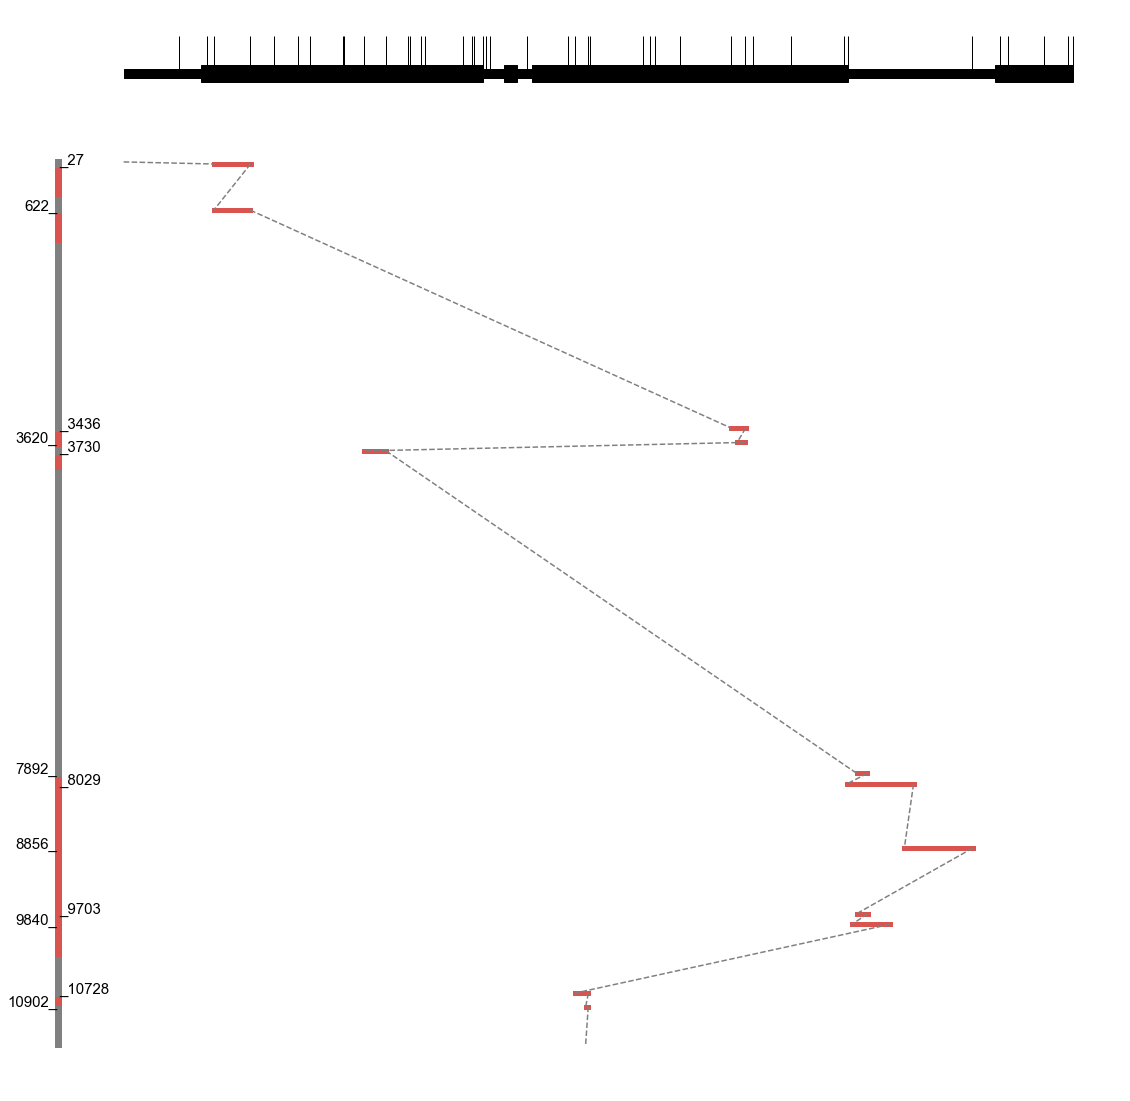

In [103]:
example_0ede86d9 = example_df_drop_du.query('read_name == "0ede86d9-315d-4475-8a7d-dd61bf80d583"')
example_4ab4074d = example_df_drop_du.query('read_name == "4ab4074d-a5f3-40cf-a3f4-d8b6c630d618"')
example_b7e0c335 = example_df_drop_du.query('read_name == "b7e0c335-b6e2-4e42-aee1-b18543d3da69"')
rDNA_detail(example_0ede86d9)
rDNA_detail(example_4ab4074d)
rDNA_detail(example_b7e0c335)

# draw mupltiple rDNA interacting plot, only contain the overlapping fragments

In [221]:
#whole rDNA unit
def rDNA_units(size_filter,intersect_df_filter):
    rDNA_cluster_size_all = intersect_df_filter.groupby(by='align1').size()
    rDNA_cluster_size_filter = rDNA_cluster_size_all[rDNA_cluster_size_all>=size_filter]
    size = rDNA_cluster_size_filter.max()
    align_name = rDNA_cluster_size_filter.index.to_list()
    align_filter = intersect_df_filter.query('align1 in @align_name')
    import matplotlib.pyplot as plt
    import matplotlib.path as mpath
    import matplotlib.patches as patches
    import seaborn as sns
    import matplotlib.font_manager as font_manager
    font_dirs = ["/public/home/lizw/software/font"]
    font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
    for font_file in font_files:
        font_manager.fontManager.addfont(font_file)
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = 20

    fig,ax = plt.subplots(1,figsize=(40,1*size))
    left = 0
    geno_max = 10000*size
    coor_list = []
    n = 0
    top = 0.93
    top_step = 0.1
    last_align = ''
    last_end = 0
    for i in align_filter.itertuples(index=False):
        _,read_name1,start1,end1,align1,read_name2,start2,end2,align2 = i
        if (align1 != last_align) and n != 0 :
            top-=top_step
            n = 0
            last_end = 0
        
        geno_start,geno_width = (n*10000/geno_max,(9372)/geno_max)
        #draw reads
        ax.plot([left+geno_start+start2/geno_max,left+geno_start+end2/geno_max],[top,top],'-',color='#d9534f',linewidth=10,zorder=1)
        if n!=0:
            ax.plot([last_end,left+geno_start+start2/geno_max],[top,top],'--',color='grey',zorder=0)

        last_align = align1
        last_end = left+geno_start+end2/geno_max
        n+=1
        
    for x in range(0,size,1):
        geno_start,geno_width = (x*10000/geno_max,(9372)/geno_max)
        #whole rDNA unit
        round_para = 0.02
        full_x = left+geno_start+geno_width
        basic_x = left+geno_start
        full_y = 0.95+0.03
        basic_y = 0.95


        round_para = 0.02
        full_x = left+geno_start+geno_width
        basic_x = left+geno_start
        full_y = 0.95+0.03
        basic_y = 0.95

        verts = [(basic_x+round_para, basic_y),
             (full_x-round_para, basic_y), # start of the lower right corner
             (full_x, basic_y), # intermediate point (as if it wasn't rounded)
             (full_x, basic_y+round_para), # end point of the lower right corner
             (full_x, full_y-round_para), # move to the next point etc.
             (full_x, full_y),
             (full_x-round_para, full_y),
             (basic_x+round_para, full_y),
             (basic_x, full_y),
             (basic_x, full_y-round_para),
             (basic_x, basic_y+round_para),
             (basic_x, basic_y),
             (basic_x+round_para, basic_y)]


        codes = [mpath.Path.MOVETO,
             mpath.Path.LINETO,
             mpath.Path.CURVE3,
             mpath.Path.CURVE3,
             mpath.Path.LINETO,
             mpath.Path.CURVE3,
             mpath.Path.CURVE3,
             mpath.Path.LINETO,
             mpath.Path.CURVE3,
             mpath.Path.CURVE3,
             mpath.Path.LINETO,
             mpath.Path.CURVE3,
             mpath.Path.CURVE3]

        rounded_verts = mpath.Path(verts, codes)
        rounded_verts = patches.PathPatch(rounded_verts, facecolor='#2BB7B3',lw=0.1)
        ax.add_patch(rounded_verts)
        each_list = list(geno_start+np.arange(0,9400,2000)/geno_max+left)
        coor_list.extend(each_list)
    
    tickslist = np.arange(0,9400,2000)
    ax.set_xlim(0,1)
    ax.xaxis.tick_top()
    ax.spines['top'].set_position(('data', 0.98))
    plt.xticks(coor_list,list(tickslist)*size,rotation=45)
    plt.yticks([])
    sns.despine(left=True,bottom=True)

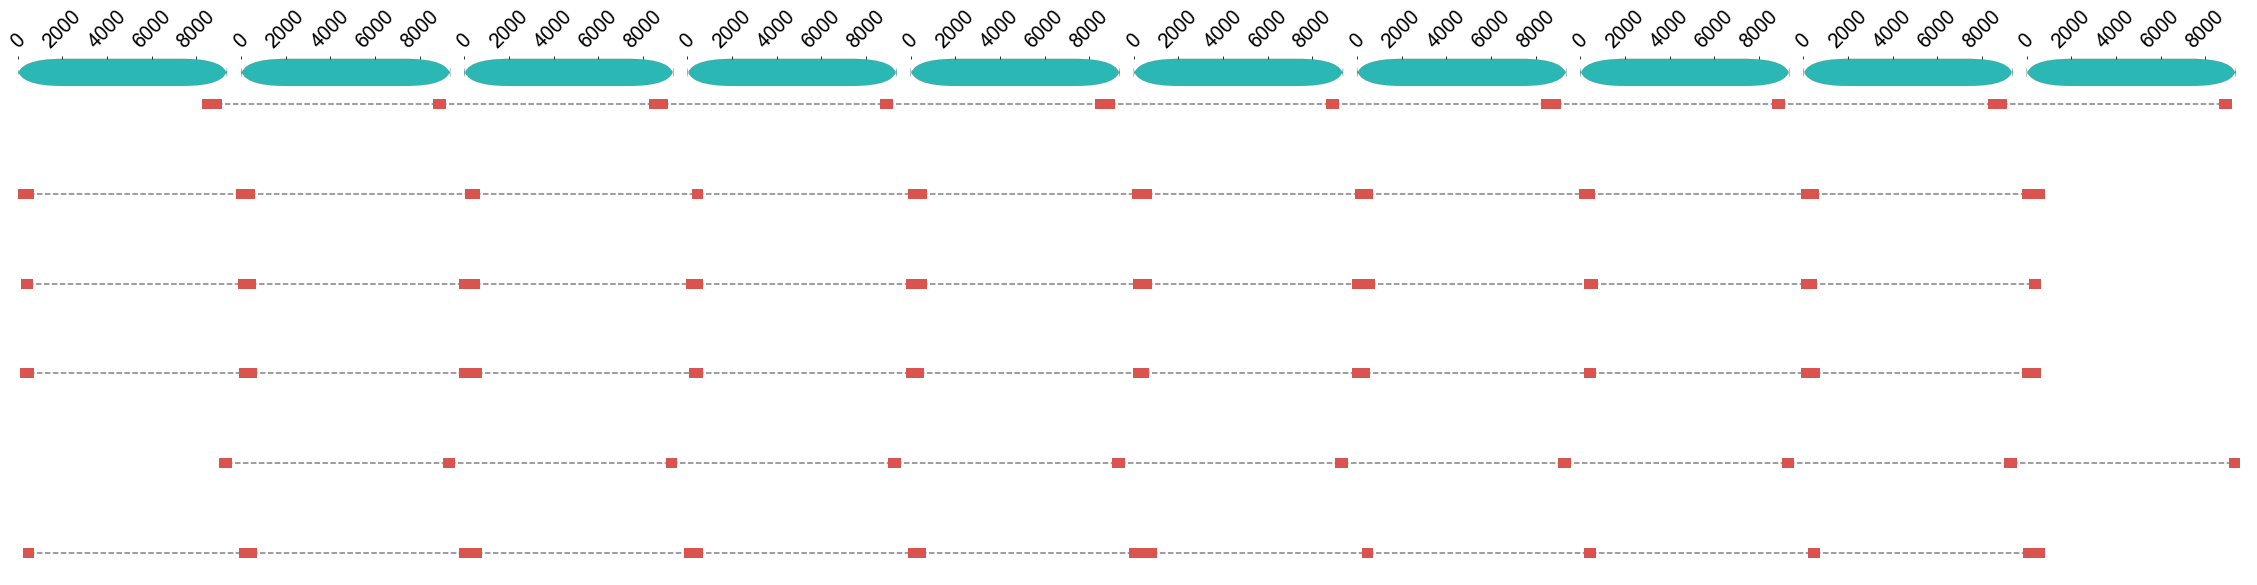

In [222]:
rDNA_units(10,intersect_df_filter)